## Experimentación con el número de equipos

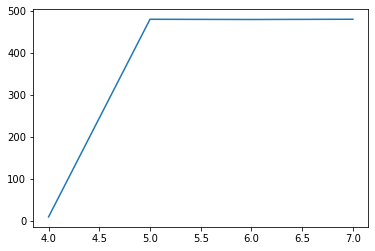

In [2]:
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from experimento import experimento
import pandas as pd


dfs = []
 # , 'SCIP', 'SAT', 'CP-SAT'
for j in ['CBC', 'SCIP', 'SAT', 'CP-SAT']:
    n_equipos, exec_time, n_iters, solvers, statuses = [], [], [], [], []
    for i in range(4,11):
        solver = pywraplp.Solver.CreateSolver(j) #CBC, SCIP, SAT, CP-SAT
#         solver.SetNumThreads(10)

        s, t = experimento(solver, i, 60 + 10*i-4, 23 * 60)

        n_equipos.append(i)
        exec_time.append(t)
        n_iters.append(solver.Iterations())
        solvers.append(j)
        statuses.append(s)
#         print(n_equipos,exec_time)
    dfs.append(pd.DataFrame({'n_equipos': n_equipos, 'exec_time': exec_time, 'n_iters': n_iters, 'solver': solvers, 'statuses':statuses}))
        
    plt.figure()
    plt.title(f'Número de equipos frente al tiempo de ejecución: {j}')
    plt.plot(n_equipos, exec_time)
    plt.savefig(j+'_exec_time.png', bbox_inches='tight')
        
    plt.figure()
    plt.title(f'Número de equipos frente al número de iteraciones: {j}')
    plt.plot(n_equipos, n_iters)
    plt.savefig(j+'_n_iters.png', bbox_inches='tight')

pd.concat(dfs, ignore_index=True).to_csv('results_nEquipos.csv', sep= ',', encoding='utf-8', index=False)

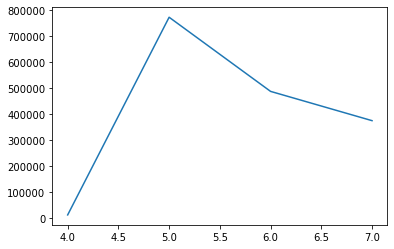

In [3]:
plt.plot(n_equipos, n_iters)

In [4]:
for s in statuses:
    print(s)

0
1
6
6


## Experimentación con distintos solvers

In [16]:
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from experimento import experimento
from collections import defaultdict

exec_time, n_iters, statuses = list(defaultdict(list) for i in range(3))

for i in ['CBC', 'SCIP', 'SAT', 'CP-SAT']:
    for j in range(50):
        solver = pywraplp.Solver.CreateSolver(i)

        s, t = experimento(solver, 4, 60, 3 * 60)

        exec_time[i].append(t)
        n_iters[i].append(solver.Iterations())
        statuses[i].append(s)

In [17]:
import pickle

results = {'exec_time' : exec_time, 'n_iters' : n_iters, 'statuses' : statuses}
with open('..\Data\experimentos.pkl', 'wb') as file:
    pickle.dump(results, file)

In [18]:
results

{'exec_time': defaultdict(list,
             {'CBC': [2.7493796348571777,
               3.0174450874328613,
               2.843316078186035,
               2.695974826812744,
               2.8108959197998047,
               2.6340391635894775,
               2.5727779865264893,
               2.5943849086761475,
               2.6181106567382812,
               2.6608498096466064,
               3.0946271419525146,
               2.5898168087005615,
               2.5709145069122314,
               2.572889566421509,
               2.6330161094665527,
               2.6076231002807617,
               2.554955244064331,
               2.672854423522949,
               2.698704719543457,
               2.5463435649871826,
               2.5948193073272705,
               2.6696436405181885,
               2.703050136566162,
               2.5651369094848633,
               2.6093051433563232,
               2.5843136310577393,
               2.641939401626587,
               2.5460472

In [24]:
import pandas as pd
df = pd.DataFrame()
df['CBC'] = results['exec_time']['CBC']
df['SCIP'] = results['exec_time']['SCIP']
df['SAT'] = results['exec_time']['SAT']
df['CP-SAT'] = results['exec_time']['CP-SAT']

## Comparación solvers

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pickle
from statsmodels.stats.multicomp import pairwise_tukeyhsd

with open('../Data/experimentos50ejec.pkl', 'rb') as file:
    res = pickle.load(file)

solvers, times = [], []

for k,v in res['exec_time'].items():
    solvers.extend([k]*len(v))
    times.extend(v)

df = pd.DataFrame()
df['solver'] = solvers
df['exec_time'] = times

### Test de normalidad

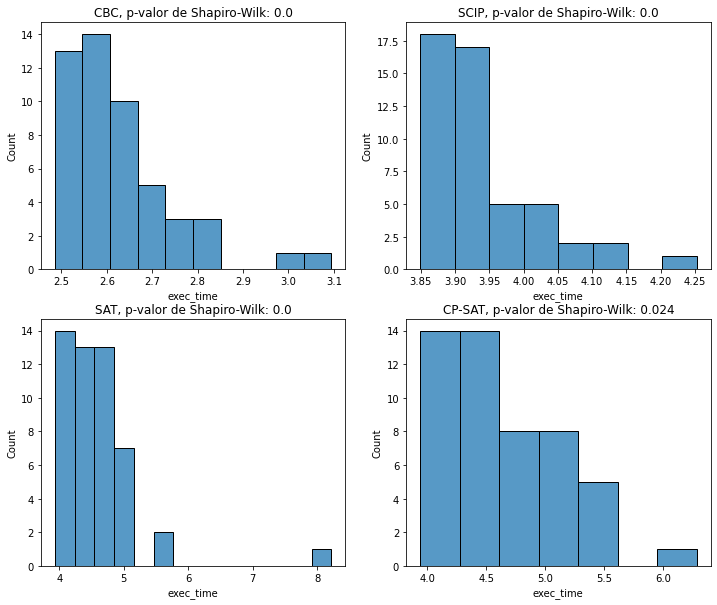

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

plt.figure(figsize=(12,10))
for i,s in enumerate(df['solver'].unique()):
    pvalor = shapiro(df[df['solver'] == s]['exec_time']).pvalue
    
    plt.subplot(2,2,i+1)
    plt.title(f'{s}, p-valor de Shapiro-Wilk: {round(pvalor, 3)}')
    sns.histplot(data = df[df['solver'] == s], x = 'exec_time')
plt.show()

No sería correcto utilizar un ANOVA ya que las poblaciones no cumplen la hipótesis de normalidad. Debido a esto, vamos a comparar los tiempos de ejecución de los distintos solvers utilizando el test de Kruskal-Wallis

### Test de Kruskal-Wallis

El pvalor del test de Kruskal-Wallis es: 6.678907690910449e-35


,CBC,CP-SAT,SAT,SCIP
CBC,1.000000e+00,2.543922e-27,6.132818e-26,5.212650e-06
CP-SAT,2.543922e-27,1.000000e+00,7.676555e-01,3.571621e-10
SAT,6.132818e-26,7.676555e-01,1.000000e+00,2.283440e-09
SCIP,5.212650e-06,3.571621e-10,2.283440e-09,1.000000e+00


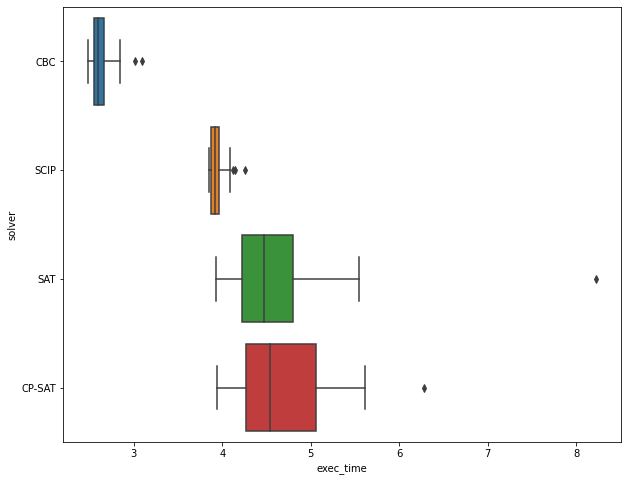

In [10]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

test_k = kruskal(*res['exec_time'].values())
print(f'El pvalor del test de Kruskal-Wallis es: {test_k.pvalue}')

plt.figure(figsize = (10,8))
sns.boxplot(data = df, x = 'exec_time', y = 'solver')

posthoc_dunn(df, val_col = 'exec_time', group_col = 'solver')

Como el p-valor es menor a 0.01 rechazamos la hipótesis nula, por lo que consideramos que existen diferencias significativas entre las poblaciones. Sin embargo, con este test no podemos saber qué solvers son significativamente más rápidos, por lo que también hemos realizado un test de Dunn entre cada par de solvers. Gracias a este hemos descubierto que el solver más rápido para nuestro problema es CBC. SCIP es significativamente más lento que CBC pero más rápido que SAT y CP-SAT, entre los que no existen diferencias significativas.